In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [7]:
df.isna().sum()

Passengers    0
dtype: int64

<AxesSubplot: xlabel='Month'>

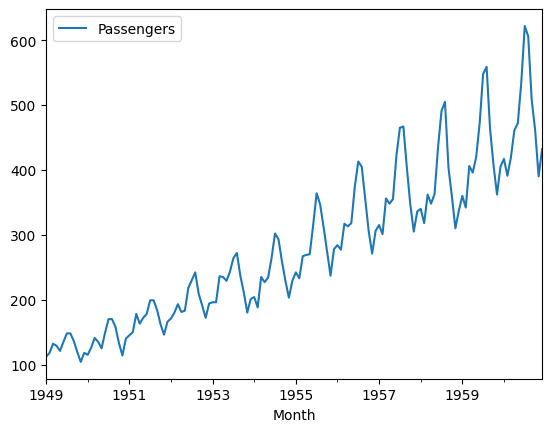

In [8]:
df.plot()

In [9]:
alpha = 0.2
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [10]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

<AxesSubplot: xlabel='Month'>

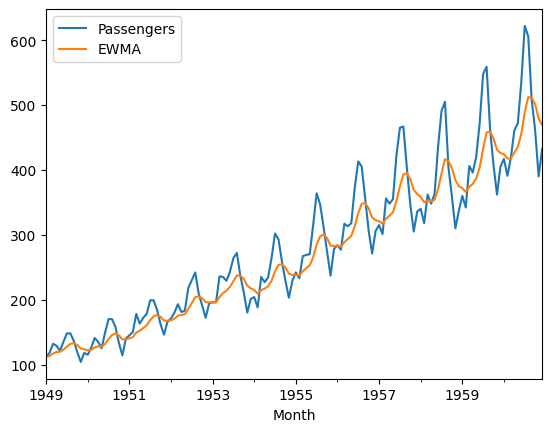

In [11]:
df.plot()

<AxesSubplot: xlabel='Month'>

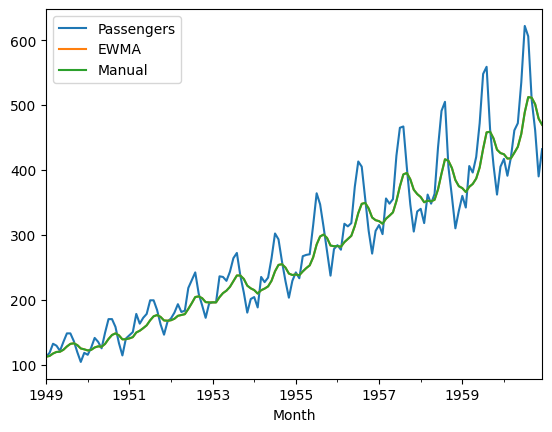

In [12]:
manual_ewma = []

for x in df['Passengers'].to_numpy():
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1-alpha) * manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)

df['Manual'] = manual_ewma

df.plot()

In [13]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [14]:
df.drop('Manual', axis=1, inplace=True)

In [15]:
!pip install -U statsmodels

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses = SimpleExpSmoothing(df['Passengers'])



/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index



DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [18]:
df.index.freq = 'MS'



In [19]:
ses = SimpleExpSmoothing(df['Passengers'], initialization_method='legacy-heuristic')

In [20]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [21]:
res

In [22]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [23]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [24]:
df

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,113.200000,112.000000
1949-03-01,132,116.960000,113.200000
1949-04-01,129,119.368000,116.960000
1949-05-01,121,119.694400,119.368000
...,...,...,...
1960-08-01,606,512.214093,488.767616
1960-09-01,508,511.371274,512.214093
1960-10-01,461,501.297019,511.371274


In [25]:
np.allclose(df['SES'], res.fittedvalues)

True

<AxesSubplot: xlabel='Month'>

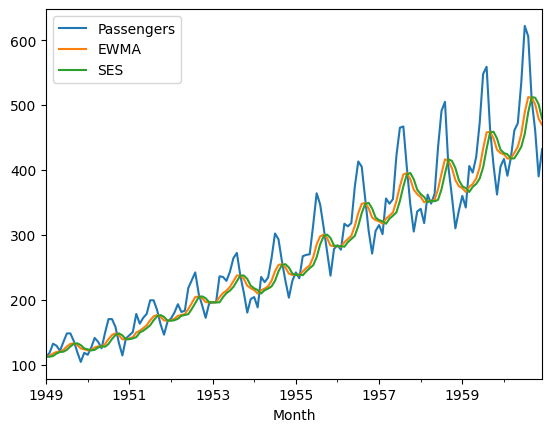

In [26]:
df.plot()

In [27]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [28]:
df['SES-1'] = df['SES'].shift(-1)

<AxesSubplot: xlabel='Month'>

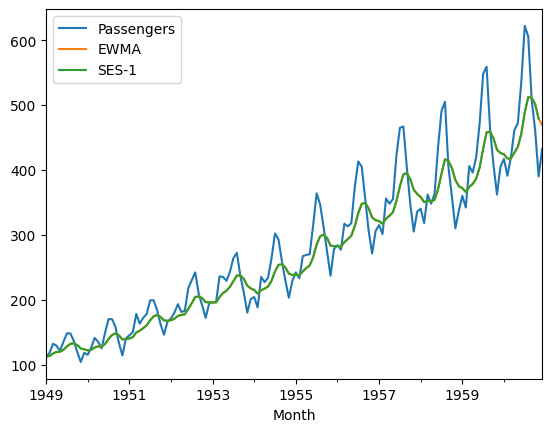

In [29]:
### NOOOOO
df[['Passengers', 'EWMA', 'SES-1']].plot()

In [30]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [31]:
ses = SimpleExpSmoothing(train['Passengers'], initialization_method='legacy-heuristic')


In [32]:
res = ses.fit()

In [33]:
# indexes - boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

<AxesSubplot: xlabel='Month'>

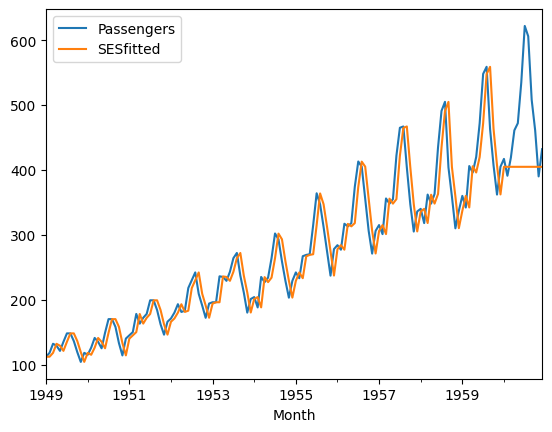

In [34]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)

df[['Passengers', 'SESfitted']].plot()

In [35]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# Holt's Linear Trend Model

## First model to learn that can find and predicts a trend line

In [36]:
from statsmodels.tsa.holtwinters import Holt

holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic'
)

In [37]:
res_h = holt.fit()

In [38]:
df['Holt'] = res_h.fittedvalues

<AxesSubplot: xlabel='Month'>

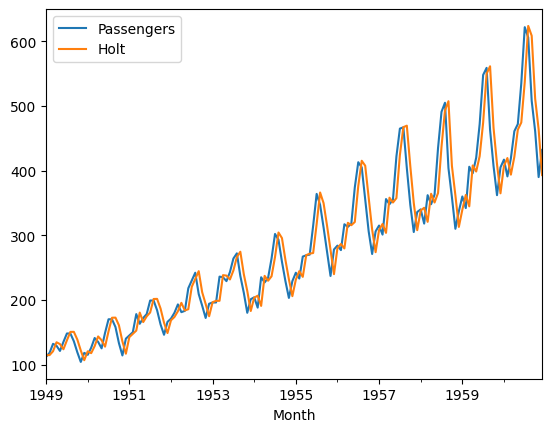

In [39]:
df[['Passengers', 'Holt']].plot()

<AxesSubplot: xlabel='Month'>

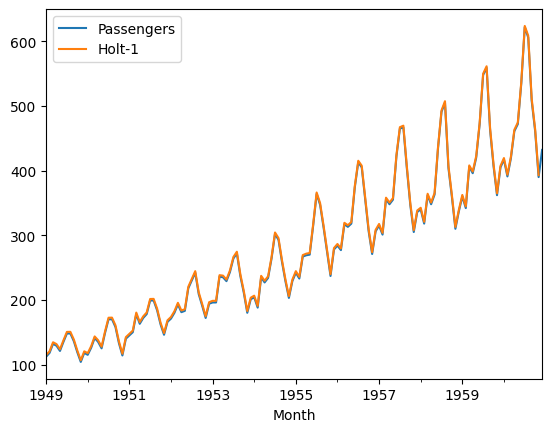

In [40]:
### NOOO !
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot()

In [41]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()

df.loc[train_idx, 'Holt'] = res_h.fittedvalues


In [42]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

<AxesSubplot: xlabel='Month'>

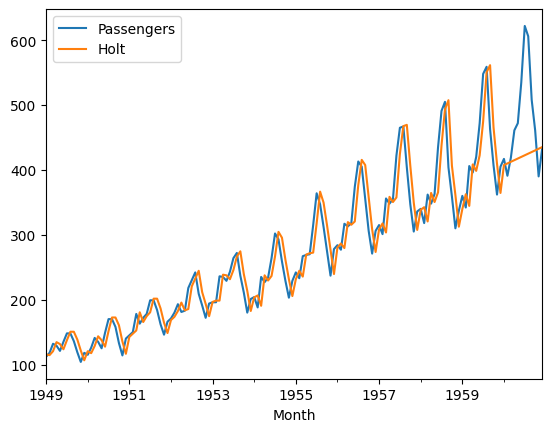

In [43]:
df[['Passengers', 'Holt']].plot()

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [45]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)

res_hw = hw.fit()

In [46]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

<AxesSubplot: xlabel='Month'>

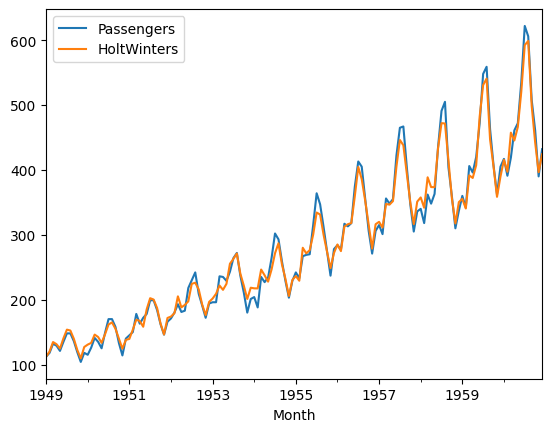

In [47]:
df[['Passengers', 'HoltWinters']].plot()

In [49]:
def rmse(y, t):
    return np.sqrt(np.mean((y-t)**2))

In [50]:
def mae(y, t):
    return np.mean(np.abs(y-t))

In [53]:
print('Train RMSE: ', rmse(train['Passengers'], res_hw.fittedvalues))
print('Test RMSE: ', rmse(test['Passengers'], res_hw.forecast(N_test)))

print('Train MAE: ', mae(train['Passengers'], res_hw.fittedvalues))
print('Test MAE: ', mae(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE:  11.62468016536331
Test RMSE:  16.980031088514917
Train MAE:  9.008002352838368
Test MAE:  13.380597703696301


Train RMSE:  9.767998356992887
Test RMSE:  15.810717687759283
Train MAE:  7.604270869387354
Test MAE:  10.30351488574514


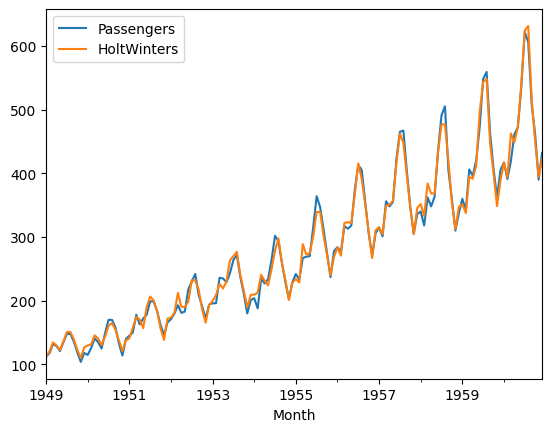

In [58]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)

res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot()

print('Train RMSE: ', rmse(train['Passengers'], res_hw.fittedvalues))
print('Test RMSE: ', rmse(test['Passengers'], res_hw.forecast(N_test)))

print('Train MAE: ', mae(train['Passengers'], res_hw.fittedvalues))
print('Test MAE: ', mae(test['Passengers'], res_hw.forecast(N_test)))

/home/ubuntu/tradingbot-env/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Train RMSE:  9.617926075028425
Test RMSE:  25.80687396111705
Train MAE:  7.112387297956744
Test MAE:  20.84489911278619


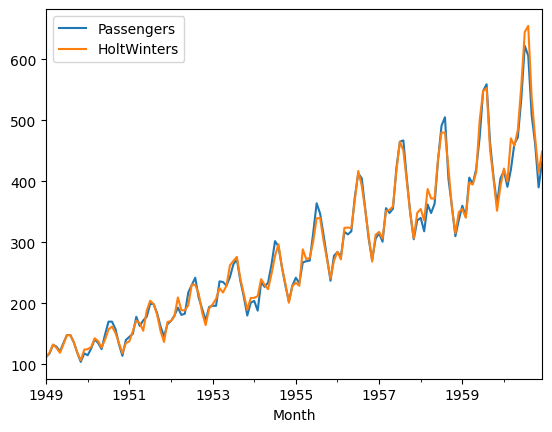

In [57]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)

res_hw = hw.fit()

df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

df[['Passengers', 'HoltWinters']].plot()

print('Train RMSE: ', rmse(train['Passengers'], res_hw.fittedvalues))
print('Test RMSE: ', rmse(test['Passengers'], res_hw.forecast(N_test)))

print('Train MAE: ', mae(train['Passengers'], res_hw.fittedvalues))
print('Test MAE: ', mae(test['Passengers'], res_hw.forecast(N_test)))